# Setup

In [14]:
# Extract and build the benchmark
!make -C io

!mkdir -p /data/lab1
!io/io-static -c lab1/iofile

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: lab1/iofile
  time: 1.857467542
speed: 8820.61 KBytes/sec


In [54]:
def strs_to_tup(strs):
    if len(strs) == 1:
        return (strs[0].strip(),None)
    else:
        return (strs[0].strip(),strs[1].strip())

def parse(cmd_out):
    tups = map(strs_to_tup, [string.split(":") for string in cmd_out])
    return dict(tups)

import time
from __future__ import print_function
from decimal import Decimal
import pandas as pd
import numpy as np
%matplotlib inline
# import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')

def label_point(x, y, ax):
    a = pd.concat({'x': x, 'y': y}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], "{:.2E}".format(Decimal(point['x'])))

# np.array expects: [[x1, y1], [x2, y2], ..., [xn, yn]]
def graph(xs, ys, save = False, save_name = "plot"):
    df = pd.DataFrame(np.array(np.column_stack((xs, ys))), columns=['x', 'y'])
    plt = df.plot.scatter(x='x', y='y',logx=True, grid=True, figsize=(20,10))
    label_point(df.x, df.y, plt)
    if save:
        fig = plt.get_figure()
        fig.savefig("{}.pdf".format(save_name))

def benchmark(flags, repeat, exe, filename, buf_sizes, io_sizes, create = False):
    runs = range(1, repeat + 1)
    outputs = []
    print("\t ==> Running {}".format(exe))
    print("\t\t ==> Reading from {}".format(filename))

    for buffer_size in buf_sizes:
        for io_size in io_sizes:
            cmd = "{} {} -b {} -t {} {}".format(exe, flags, buffer_size, io_size, filename)
            if "-v" not in flags:
                cmd = "time -p " + cmd
            discard = !{cmd}

            if create:
                created = !io/io-static -t {str(io_size)} -c lab1/iofile

            results = []
            for i in runs:
                out = !{cmd}
                parsed = parse(out)
                results.append(parsed)

            times = [float(item['time']) for item in results]
            speeds = [float(item['speed'].split(' ')[0]) for item in results] # Need to split by ' ' because output speed has units attached to it (see io.c)
            avg_time = sum(times) / len(runs)
            avg_speed = sum(speeds) / len(runs)
            buf_sz = int(results[0]['buffersize'])
            tot_sz = int(results[0]['totalsize'])
            print("\t\t\t{0:2} bytes {1:2} bytes ({2:.2f} KBytes/sec): {3:.6f}s".format(buf_sz, tot_sz, avg_speed, avg_time))
            outputs.append({'buffersize':buffer_size, 'time':avg_time, 'speed':avg_speed, 'iosize':tot_sz})
    return outputs

# Reads

## Constant IO/Varying Buffer (with cache, static/dynamic)

* Total size: 16MB (default)
* Buffer: varies from 512 to 512 * 2^16
* (io.c modified to output kbytes/sec in same format as other params)
* Run multiple times then average
* Prevent warmup effect

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			512 bytes 16777216 bytes (40136.14 KBytes/sec): 0.408211s
			1024 bytes 16777216 bytes (66895.21 KBytes/sec): 0.244920s
			2048 bytes 16777216 bytes (101830.38 KBytes/sec): 0.160895s
			4096 bytes 16777216 bytes (135428.55 KBytes/sec): 0.120979s
			8192 bytes 16777216 bytes (157580.88 KBytes/sec): 0.103972s
			16384 bytes 16777216 bytes (165759.84 KBytes/sec): 0.098842s
			32768 bytes 16777216 bytes (123339.71 KBytes/sec): 0.132836s
			65536 bytes 16777216 bytes (173762.71 KBytes/sec): 0.094289s
			131072 bytes 16777216 bytes (170394.96 KBytes/sec): 0.096153s
			262144 bytes 16777216 bytes (167017.93 KBytes/sec): 0.098097s
			524288 bytes 16777216 bytes (164453.41 KBytes/sec): 0.099627s
			1048576 bytes 16777216 bytes (168305.72 KBytes/sec): 0.097347s
			2097152 bytes 16777216 bytes (165398.18 KBytes/sec): 0.099058s
			4194304 bytes 16777216 bytes (160031.78 KBytes/sec): 0.102380s
			8388608 bytes 16777216 bytes (148370.52 K

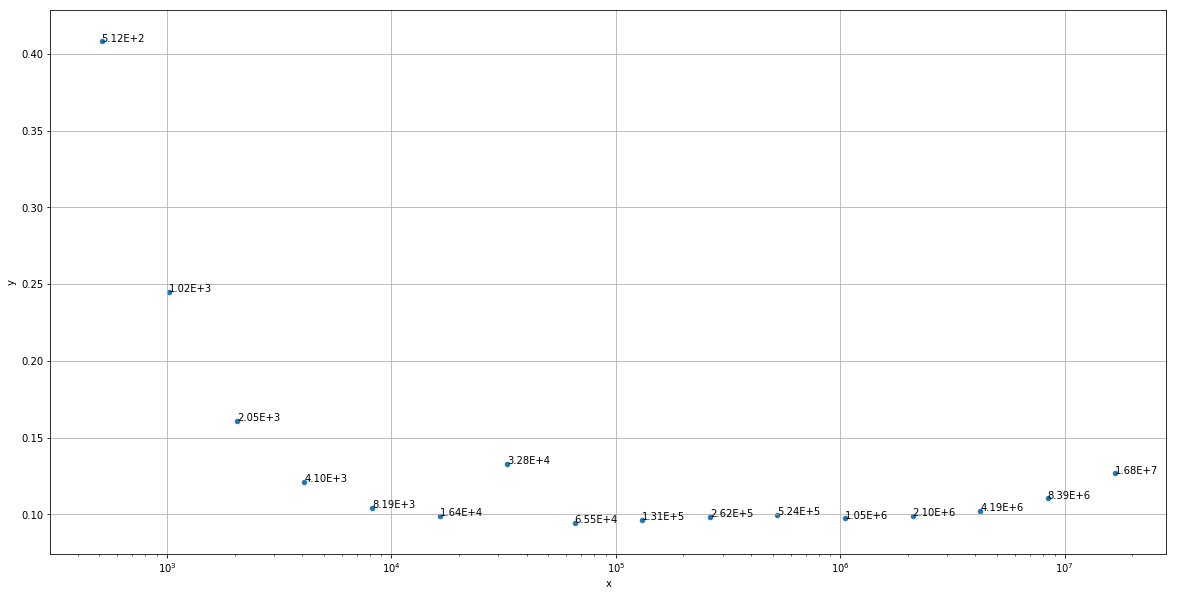

In [57]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)

results_iofile = benchmark("-v -r", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES)
# results_zero = benchmark("-v -r", 10, "io/io-static", "/dev/zero")
# results_random = benchmark("-v -r", 10, "io/io-static", "/dev/random")

saveas = "static_maxra_64_const_io_flags_vr_runs_12"
graph([item['buffersize'] for item in results_iofile], [item['buffersize'] for item in results_iofile], save = True, save_name = saveas)

### DTrace


In [27]:
# D Language scripts
io_syscall_script = """
syscall:::entry
/execname == "io-static"/
{
    @a[probefunc] = count();
}
"""

TOTAL_SIZE = 16*1024*1024
BUFFER_SIZE = 512
values = dict()

# Callback invoked to process the aggregation
def simple_out(a, b, c, d):
    key = c[0]
    count = d
    if key in values:
        values[key] += d
    else:
        values[key] = d

# Create a seperate thread to run the DTrace instrumentation
dtrace_thread = DTraceConsumerThread(io_syscall_script,
                                    chew_func=None,
                                    chewrec_func=None,
                                    walk_func=simple_out,
                                    sleep=1)

# Start the DTrace instrumentation
dtrace_thread.start()

# Display header to indicate that the benchmarking has started
print_header(["Starting io-static read performance measurement"])

# Run the io-static benchmark    
output_predicate = !io/io-static -r -b {str(BUFFER_SIZE)} -t {str(TOTAL_SIZE)} iofile
        
# The benchmark has completed - stop the DTrace instrumentation
dtrace_thread.stop()
dtrace_thread.join()

# Print the performance of both runs
print("With predicate {} KiBytes/sec".format(output_predicate[0].split(' ')[0]))

# Display footer to indicate that the benchmarking has finished
print_footer(["Finished io-static read performance measurement"])

********************************************************************************
* Starting io-static read performance measurement
********************************************************************************
With predicate speed: KiBytes/sec
********************************************************************************
* Finished io-static read performance measurement
********************************************************************************


## Buffer Size Constant/Vary IO

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			16384 bytes 16384 bytes (50180.44 KBytes/sec): 0.000322s
			16384 bytes 32768 bytes (74793.36 KBytes/sec): 0.000431s
			16384 bytes 65536 bytes (100208.74 KBytes/sec): 0.000641s
			16384 bytes 131072 bytes (125510.15 KBytes/sec): 0.001020s
			16384 bytes 262144 bytes (145511.30 KBytes/sec): 0.001759s
			16384 bytes 524288 bytes (157073.91 KBytes/sec): 0.003260s
			16384 bytes 1048576 bytes (161016.91 KBytes/sec): 0.006393s
			16384 bytes 2097152 bytes (165917.99 KBytes/sec): 0.012344s
			16384 bytes 4194304 bytes (168242.91 KBytes/sec): 0.024346s
			16384 bytes 8388608 bytes (170032.34 KBytes/sec): 0.048179s
			16384 bytes 16777216 bytes (170740.29 KBytes/sec): 0.095959s
Saved plot at static_create_read_y_speed_maxra_64_const_buf_16kb_flags_vrBds_runs_12


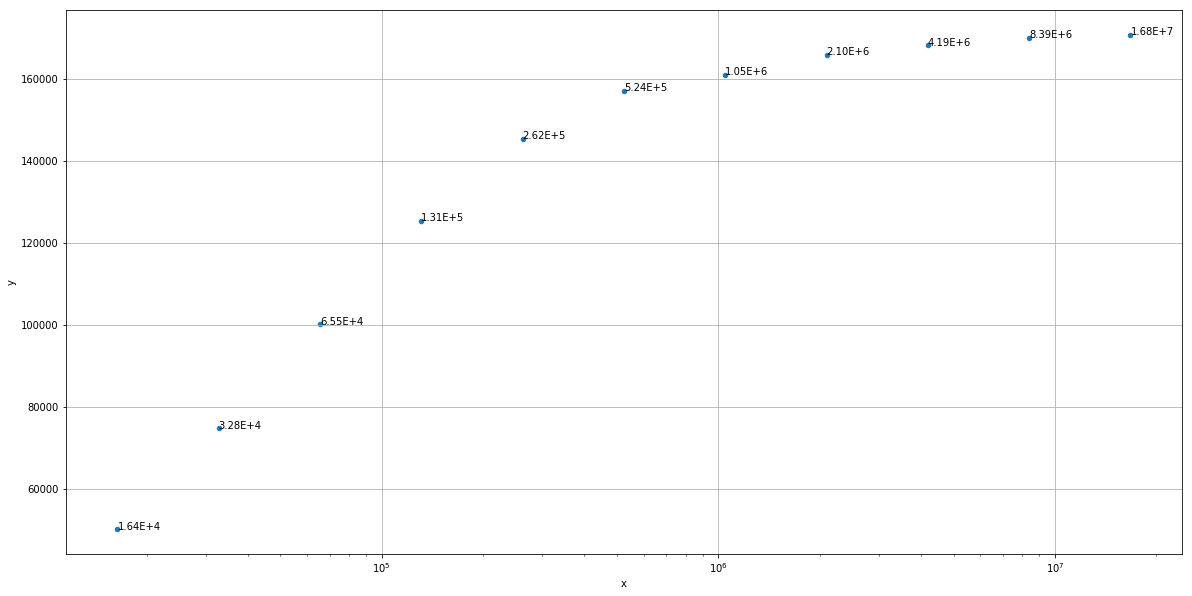

In [55]:
# Setup
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(5, 16)]
BUFFER_SIZES = [512 * 2 ** 5] # Keep constant at default 16KB

results_iofile = benchmark("-v -r", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True)

saveas = "static_create_read_y_speed_maxra_64_const_buf_16kb_flags_vrBds_runs_12"
graph([item['iosize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)
print("Saved plot at {}".format(saveas))

# Write

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			512 bytes 16777216 bytes (8989.32 KBytes/sec): 1.853435s
			1024 bytes 16777216 bytes (9301.63 KBytes/sec): 1.761498s
			2048 bytes 16777216 bytes (9090.66 KBytes/sec): 1.822656s
			4096 bytes 16777216 bytes (9540.43 KBytes/sec): 1.717341s
			8192 bytes 16777216 bytes (9498.64 KBytes/sec): 1.725008s
			16384 bytes 16777216 bytes (9548.72 KBytes/sec): 1.715866s
			32768 bytes 16777216 bytes (9531.05 KBytes/sec): 1.719057s
			65536 bytes 16777216 bytes (9513.46 KBytes/sec): 1.722316s
			131072 bytes 16777216 bytes (9548.10 KBytes/sec): 1.715985s
			262144 bytes 16777216 bytes (9542.78 KBytes/sec): 1.716951s
			524288 bytes 16777216 bytes (9543.25 KBytes/sec): 1.716832s
			1048576 bytes 16777216 bytes (9488.82 KBytes/sec): 1.726863s
			2097152 bytes 16777216 bytes (9452.87 KBytes/sec): 1.733325s
			4194304 bytes 16777216 bytes (9501.80 KBytes/sec): 1.724326s
			8388608 bytes 16777216 bytes (9496.66 KBytes/sec): 1.725319s
			167

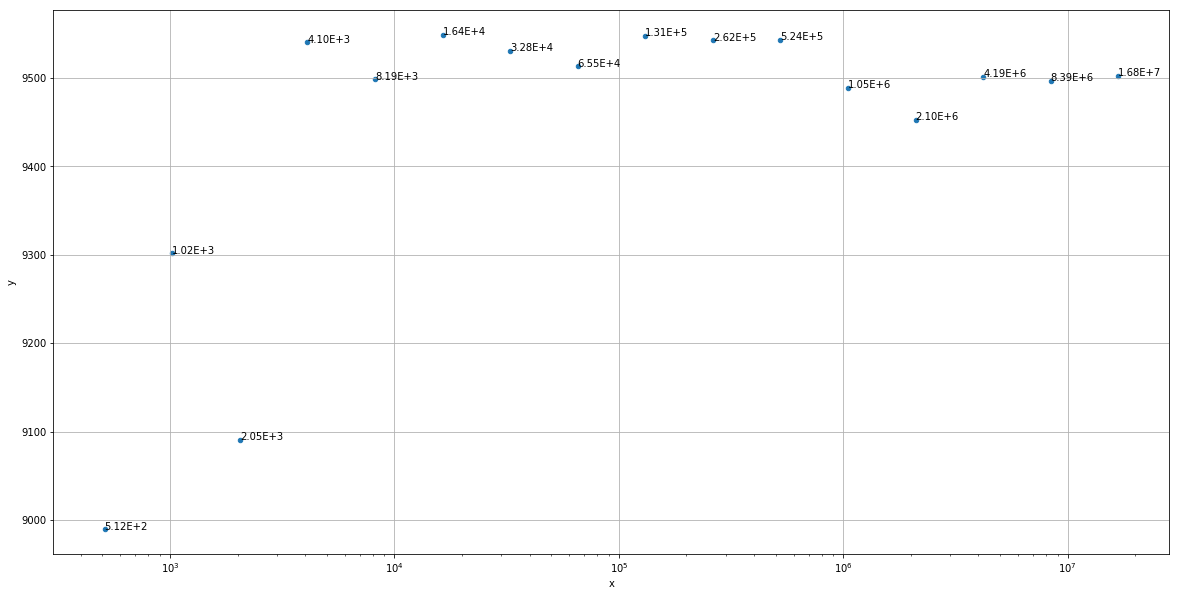

In [3]:
BUF_START = 512
BUFFER_SIZES = [BUF_START * 2 ** exp for exp in range(0, 16)]
IO_SIZES = [BUFFER_SIZES[-1]] # Keep constant at default 16MB (last value of BUFFER_SIZES)

results_iofile = benchmark("-v -w", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES)

saveas = "static_write_y_speed_maxra_64_const_io_flags_vw_runs_12"
print("Saving plot at {}".format(saveas))
graph([item['buffersize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)

	 ==> Running io/io-static
		 ==> Reading from lab1/iofile
			16384 bytes 16384 bytes (46948.31 KBytes/sec): 0.000342s
			16384 bytes 32768 bytes (65991.17 KBytes/sec): 0.000599s
			16384 bytes 65536 bytes (108169.74 KBytes/sec): 0.000592s
			16384 bytes 131072 bytes (111151.81 KBytes/sec): 0.001152s
			16384 bytes 262144 bytes (137054.44 KBytes/sec): 0.001868s
			16384 bytes 524288 bytes (116912.08 KBytes/sec): 0.004407s
			16384 bytes 1048576 bytes (109518.39 KBytes/sec): 0.009355s
			16384 bytes 2097152 bytes (12024.32 KBytes/sec): 0.173322s
			16384 bytes 4194304 bytes (9629.81 KBytes/sec): 0.427016s
			16384 bytes 8388608 bytes (9060.48 KBytes/sec): 0.905519s
			16384 bytes 16777216 bytes (8957.42 KBytes/sec): 1.855805s
Saving plot at static_create_write_y_speed_maxra_64_const_buf_16kb_flags_vw_runs_12


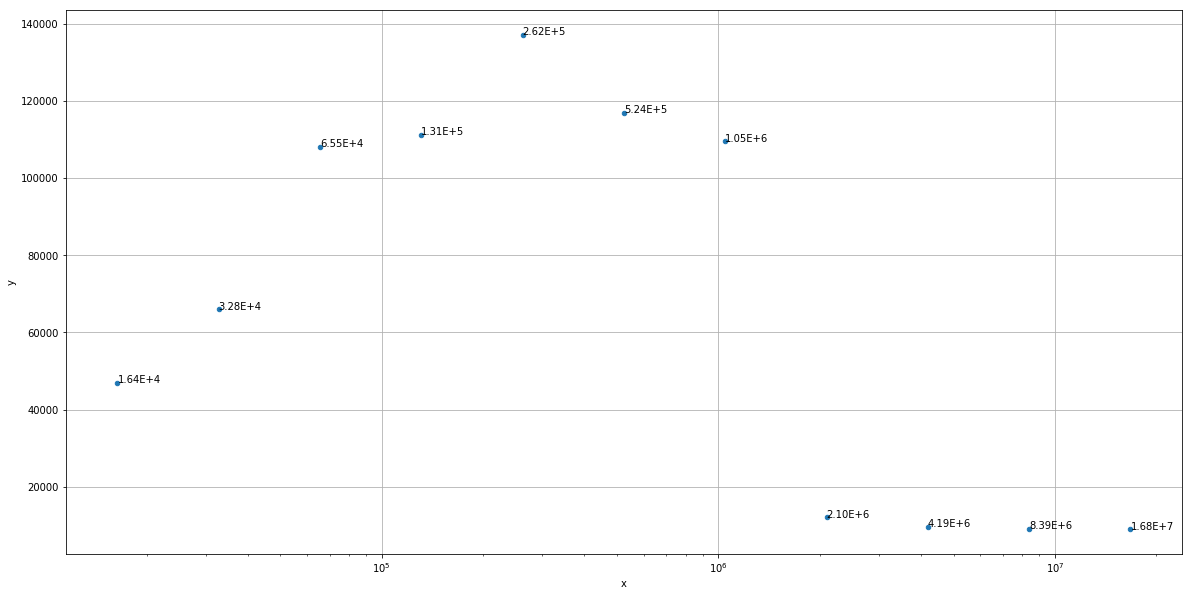

In [2]:
IO_START = 512
IO_SIZES = [IO_START * 2 ** exp for exp in range(5, 16)]
BUFFER_SIZES = [512 * 2 ** 5] # Keep constant at default 16KB

results_iofile = benchmark("-v -w", 12, "io/io-static", "lab1/iofile", BUFFER_SIZES, IO_SIZES, create = True)

saveas = "static_create_write_y_speed_maxra_64_const_buf_16kb_flags_vw_runs_12"
print("Saving plot at {}".format(saveas))
graph([item['iosize'] for item in results_iofile], [item['speed'] for item in results_iofile], save = True, save_name = saveas)